# __Papers:__
> Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> Biological pattern formation: fmm basic mechanisms ta complex structures

> [Link](https://doi.org/10.1103/RevModPhys.66.1481)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The main PDE that the training dataset is created is as follow:

<h3><center>$\partial_t a = D_a (\partial_x^2 + \partial_y^2)a + \rho_a \frac{a^2 s}{1 + \kappa_a a^2} - \mu_a a + \sigma_a$</center></h3>

<h3><center>$\partial_t s = D_s (\partial_x^2 + \partial_y^2)s - \rho_s \frac{a^2 s}{1 + \kappa_a a^2} + \sigma_s$</center></h3>

With parameters  :
- $D_a = 0.005, \quad D_s=0.2$.
- $\mu_a = 0.01$.
- $\sigma_a = 0.0, \quad \sigma_s=0.02$.
- $\rho_a=0.01, \quad \rho_s = 0.02, \quad \kappa_a=0.25$

Using the following transformations
- <h3>$\tilde{x} =  \frac{x}{\sqrt{D_s}} , \qquad \tilde{y} =  \frac{y}{\sqrt{D_s}}$.</h3>
- <h3>$\gamma =  \frac{D_s}{D_a}$.</h3>
- <h3>$\tilde{\mu}_a =  \gamma \mu_a, \qquad \tilde{\rho_a} = \gamma \rho_a, \qquad \tilde{\sigma}_a = \gamma \sigma_a$.</h3>

**and the dimensionless equation obtains as**

<h3><center>$ \gamma \partial_t a = (\partial_\tilde{x}^2 + \partial_\tilde{y}^2)a + \tilde{\rho}_a\frac{a^2 s}{1 + \kappa_a a^2} - \tilde{\mu}_a a + \tilde{\sigma}_a$</center></h3>

<h3><center>$\partial_t s =  (\partial_\tilde{x}^2 + \partial_\tilde{y}^2)s - \rho_s \frac{a^2 s}{1 +\kappa_a a^2} + \sigma_s$</center></h3>

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.005, dtype=tf.float32, name="D_a")#
            self.D_s = tf.constant(0.2, dtype=tf.float32, name="D_s")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_s",
                                  #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
                                                                                   
            self.gamma = tf.math.divide(self.D_s, self.D_a, name="gamma")
                                                                                   
            self.sigma_a_tilde = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a_tilde",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10)
                                      )#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a_tilde",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a_tilde",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                    name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32, name="rho_s")#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")                
                
        self.lb_tilde, self.ub_tilde =  self.net_lb_ub_transform(self.lb, self.ub)
        self.x_tilde, self.y_tilde = self.net_xy_transform(self.x_tf, self.y_tf)
        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tilde, self.y_tilde, self.t_tf)
        

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss = self.loss_1 + self.loss_a + self.loss_s 

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        #H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        H = 2.0*(X - self.lb_tilde)/(self.ub_tilde - self.lb_tilde) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def _xy_transform(self, val_tensor):
        """x or y to x_tilde, y_tilde"""
        return val_tensor/tf.math.sqrt(self.D_s)        
    
                                                                                   
    def net_xy_transform(self, x, y):
        """x and y to x_tilde, y_tilde"""
        x_tilde = self._xy_transform(x)
        y_tilde = self._xy_transform(y)
        
        return (x_tilde, y_tilde)
    
    def net_lb_ub_transform(self, lb, ub):        
        
        lb_tilde = tf.Variable([self._xy_transform(lb[0]),
                             self._xy_transform(lb[1]),
                             lb[2]])
        
        ub_tilde = tf.Variable([self._xy_transform(ub[0]),
                             self._xy_transform(ub[1]),
                             ub[2]])          
        
        return (lb_tilde, ub_tilde)
            
    def net_ASDM(self, x, y, t):        
        sigma_a_tilde = self.sigma_a_tilde
        mu_a_tilde = self.mu_a_tilde
        rho_a_tilde = self.rho_a_tilde
        kappa_a = self.kappa_a
                                                                                   
        rho_s = self.rho_s
        sigma_s = self.sigma_s
                                                                                   
        gamma = self.gamma
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        
        
        a_t = tf.gradients(a, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a*a*s/(1 + kappa_a*a*a)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = gamma*a_t - (a_xx + a_yy) - rho_a_tilde*f + mu_a_tilde*a - sigma_a_tilde
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s   
        
        
        return a, s, f_a, f_s 
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s,gamma, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a_tilde: {D_a.tolist()}, D_s: {D_s.tolist()}, gamma: {gamma.tolist()}\n"
              f"sigma_a_tilde: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a_tilde: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a_tilde: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)                
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_gamma = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a_tilde: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_D_a[it] = _get_val(D_a_value)
                arr_D_s[it] = _get_val(D_s_value)
                arr_gamma[it] = _get_val(gamma_value)
                arr_sigma_a[it] = _get_val(sigma_a_value)
                arr_sigma_s[it] = _get_val(sigma_s_value)
                arr_rho_a[it] = _get_val(rho_a_value)
                arr_rho_s[it] = _get_val(rho_s_value)
                arr_mu_a[it] = _get_val(mu_a_value)
                arr_kappa_a[it] = _get_val(kappa_a_value)
                                
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)], 'gamma': arr_gamma[:(it+1)], 
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], arr_total_loss_a[:(it+1)], arr_total_loss_s[:(it+1)], params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            arr_D_a[it] = _get_val(D_a_value)
            arr_D_s[it] = _get_val(D_s_value)
            arr_gamma[it] = _get_val(gamma_value)
            arr_sigma_a[it] = _get_val(sigma_a_value)
            arr_sigma_s[it] = _get_val(sigma_s_value)
            arr_rho_a[it] = _get_val(rho_a_value)
            arr_rho_s[it] = _get_val(rho_s_value)
            arr_mu_a[it] = _get_val(mu_a_value)
            arr_kappa_a[it] = _get_val(kappa_a_value)
            
        # end for it
        params = {'D_a': arr_D_a, 'D_s': arr_D_s, 'gamma': arr_gamma, 
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, arr_total_loss_a, arr_total_loss_s, params)
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s, self.gamma,
                                          self.sigma_a_tilde, self.sigma_s,
                                          self.rho_a_tilde, self.rho_s,
                                          self.mu_a_tilde, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s, params_estimates = \
model.train_batch(5000, batch_size=N*T//128, early_stop_thresh=4.0, print_iter=50)

It: 0, loss_a  : 657.29650056, loss_s  : 5118.75940129, loss  : 24351.75,
D_a_tilde: [1.0126467943191528], D_s: 0.20000000298023224, gamma:[0.1975022256374359]
sigma_a_tilde: [0.08802410215139389], sigma_s: [0.9451506733894348]
rho_a_tilde: [1.1057685613632202], rho_s: [1.0877106189727783]
mu_a_tilde: [0.8964109420776367], kappa_a: [0.8949483036994934], 
Time:4.94

It: 50, loss_a  : 5.31581908, loss_s  : 7.14600210, loss  : 9906.29,
D_a_tilde: [0.9504840970039368], D_s: 0.20000000298023224, gamma:[0.21041908860206604]
sigma_a_tilde: [0.07752355933189392], sigma_s: [0.8197302222251892]
rho_a_tilde: [1.098785400390625], rho_s: [1.1990727186203003]
mu_a_tilde: [0.8186039328575134], kappa_a: [0.8589248657226562], 
Time:117.80

It: 100, loss_a  : 2.94829147, loss_s  : 4.76207345, loss  : 9900.98,
D_a_tilde: [0.911630392074585], D_s: 0.20000000298023224, gamma:[0.21938715875148773]
sigma_a_tilde: [0.023172525689005852], sigma_s: [0.743383526802063]
rho_a_tilde: [1.0917840003967285], rho_s: [

It: 1150, loss_a  : 7.14225499, loss_s  : 0.49726328, loss  : 60.39,
D_a_tilde: [0.03176601603627205], D_s: 0.20000000298023224, gamma:[6.296036720275879]
sigma_a_tilde: [0.0], sigma_s: [0.019273674115538597]
rho_a_tilde: [0.32470703125], rho_s: [0.018526962026953697]
mu_a_tilde: [0.33191680908203125], kappa_a: [0.23067213594913483], 
Time:117.99

It: 1200, loss_a  : 4.77314707, loss_s  : 0.40776846, loss  : 41.07,
D_a_tilde: [0.03176601603627205], D_s: 0.20000000298023224, gamma:[6.296036720275879]
sigma_a_tilde: [0.0], sigma_s: [0.019165288656949997]
rho_a_tilde: [0.34375932812690735], rho_s: [0.019017653539776802]
mu_a_tilde: [0.34740301966667175], kappa_a: [0.23930519819259644], 
Time:118.03

It: 1250, loss_a  : 3.57123696, loss_s  : 0.37464604, loss  : 32.00,
D_a_tilde: [0.03176601603627205], D_s: 0.20000000298023224, gamma:[6.296036720275879]
sigma_a_tilde: [0.0], sigma_s: [0.01919514313340187]
rho_a_tilde: [0.3538178503513336], rho_s: [0.01874425821006298]
mu_a_tilde: [0.3579306

In [22]:
loss2, loss_a2, loss_s2, params_estimates2 = \
model.train_batch(5000, batch_size=N*T//128, early_stop_thresh=0.5, print_iter=50)

It: 0, loss_a  : 0.69307256, loss_s  : 0.24047638, loss  : 4.43,
D_a_tilde: [0.0309250820428133], D_s: 0.20000000298023224, gamma:[6.467242240905762]
sigma_a_tilde: [0.0], sigma_s: [0.01893123984336853]
rho_a_tilde: [0.3824346959590912], rho_s: [0.019068533554673195]
mu_a_tilde: [0.38060837984085083], kappa_a: [0.25452321767807007], 
Time:2.42

It: 50, loss_a  : 28.29129905, loss_s  : 3.16355360, loss  : 3530.16,
D_a_tilde: [0.03176603093743324], D_s: 0.20000000298023224, gamma:[6.29603385925293]
sigma_a_tilde: [0.0], sigma_s: [0.02247403934597969]
rho_a_tilde: [0.26944655179977417], rho_s: [0.02080702595412731]
mu_a_tilde: [0.2803041636943817], kappa_a: [0.21077965199947357], 
Time:118.03

It: 100, loss_a  : 14.08511430, loss_s  : 1.16478693, loss  : 191.67,
D_a_tilde: [0.03176603093743324], D_s: 0.20000000298023224, gamma:[6.29603385925293]
sigma_a_tilde: [0.0], sigma_s: [0.019286371767520905]
rho_a_tilde: [0.2715122103691101], rho_s: [0.0178537480533123]
mu_a_tilde: [0.2904863357543

It: 1150, loss_a  : 1.05225768, loss_s  : 0.45699639, loss  : 15.20,
D_a_tilde: [0.031766027212142944], D_s: 0.20000000298023224, gamma:[6.296034336090088]
sigma_a_tilde: [0.0], sigma_s: [0.01896865852177143]
rho_a_tilde: [0.3869342803955078], rho_s: [0.01951865665614605]
mu_a_tilde: [0.3845898509025574], kappa_a: [0.2564096450805664], 
Time:118.44

It: 1200, loss_a  : 0.80666687, loss_s  : 0.42596772, loss  : 6.84,
D_a_tilde: [0.03176279366016388], D_s: 0.20000000298023224, gamma:[6.296675682067871]
sigma_a_tilde: [0.00036750626168213785], sigma_s: [0.019360531121492386]
rho_a_tilde: [0.38819804787635803], rho_s: [0.01893802173435688]
mu_a_tilde: [0.385809063911438], kappa_a: [0.2562551498413086], 
Time:118.45

It: 1250, loss_a  : 0.74691474, loss_s  : 0.40749267, loss  : 6.07,
D_a_tilde: [0.031638287007808685], D_s: 0.20000000298023224, gamma:[6.321455001831055]
sigma_a_tilde: [0.0005503028514795005], sigma_s: [0.019175928086042404]
rho_a_tilde: [0.38885435461997986], rho_s: [0.01941

It: 2300, loss_a  : 0.44558712, loss_s  : 0.23519498, loss  : 7.02,
D_a_tilde: [3.3878467082977295], D_s: 0.20000000298023224, gamma:[0.059034548699855804]
sigma_a_tilde: [0.0011733509600162506], sigma_s: [0.019347116351127625]
rho_a_tilde: [0.3898368179798126], rho_s: [0.01913401484489441]
mu_a_tilde: [0.3890838027000427], kappa_a: [0.2546425461769104], 
Time:118.38

It: 2350, loss_a  : 0.40301244, loss_s  : 0.22571302, loss  : 4.31,
D_a_tilde: [3.479757070541382], D_s: 0.20000000298023224, gamma:[0.05747527629137039]
sigma_a_tilde: [0.0015610343543812633], sigma_s: [0.018965313211083412]
rho_a_tilde: [0.3897463381290436], rho_s: [0.019181830808520317]
mu_a_tilde: [0.3895651698112488], kappa_a: [0.2545814514160156], 
Time:118.24

It: 2400, loss_a  : 0.50066971, loss_s  : 0.22492394, loss  : 11.78,
D_a_tilde: [3.342231273651123], D_s: 0.20000000298023224, gamma:[0.05984026566147804]
sigma_a_tilde: [0.0012902752496302128], sigma_s: [0.018940605223178864]
rho_a_tilde: [0.3900814354419708

It: 3450, loss_a  : 1.00320462, loss_s  : 0.47116562, loss  : 9.24,
D_a_tilde: [0.031766023486852646], D_s: 0.20000000298023224, gamma:[6.296035289764404]
sigma_a_tilde: [0.0008328062249347568], sigma_s: [0.01908046007156372]
rho_a_tilde: [0.38916146755218506], rho_s: [0.01919003389775753]
mu_a_tilde: [0.38732093572616577], kappa_a: [0.2559540569782257], 
Time:118.33

It: 3500, loss_a  : 0.78843432, loss_s  : 0.42558212, loss  : 6.59,
D_a_tilde: [0.031766023486852646], D_s: 0.20000000298023224, gamma:[6.296035289764404]
sigma_a_tilde: [0.0010427924571558833], sigma_s: [0.019045064225792885]
rho_a_tilde: [0.3912062644958496], rho_s: [0.018811596557497978]
mu_a_tilde: [0.389010488986969], kappa_a: [0.25551876425743103], 
Time:118.36

It: 3550, loss_a  : 0.69145451, loss_s  : 0.39553847, loss  : 7.28,
D_a_tilde: [0.031766023486852646], D_s: 0.20000000298023224, gamma:[6.296035289764404]
sigma_a_tilde: [0.0011044286657124758], sigma_s: [0.019463488832116127]
rho_a_tilde: [0.391136169433593

It: 4600, loss_a  : 0.49222739, loss_s  : 0.32392373, loss  : 5.47,
D_a_tilde: [0.026754433289170265], D_s: 0.20000000298023224, gamma:[7.475396633148193]
sigma_a_tilde: [0.0017711074324324727], sigma_s: [0.019786065444350243]
rho_a_tilde: [0.39521321654319763], rho_s: [0.019390298053622246]
mu_a_tilde: [0.39476874470710754], kappa_a: [0.2552081048488617], 
Time:118.43

It: 4650, loss_a  : 0.46617602, loss_s  : 0.29721545, loss  : 6.61,
D_a_tilde: [0.005528404843062162], D_s: 0.20000000298023224, gamma:[36.17679977416992]
sigma_a_tilde: [0.0021380481775850058], sigma_s: [0.018928231671452522]
rho_a_tilde: [0.3944132626056671], rho_s: [0.018941717222332954]
mu_a_tilde: [0.39385703206062317], kappa_a: [0.2547171413898468], 
Time:118.32

It: 4700, loss_a  : 0.51893304, loss_s  : 0.28397657, loss  : 10.74,
D_a_tilde: [0.0083936071023345], D_s: 0.20000000298023224, gamma:[23.82765769958496]
sigma_a_tilde: [0.002088838256895542], sigma_s: [0.019392119720578194]
rho_a_tilde: [0.39376765489578

In [30]:
loss2, loss_a3, loss_s3, params_estimates3 = \
model.train_batch(5000, batch_size=N*T//128, early_stop_thresh=1.0, print_iter=50)

It: 0, loss_a  : 0.30850903, loss_s  : 0.19836192, loss  : 2.52,
D_a_tilde: [0.009680372662842274], D_s: 0.20000000298023224, gamma:[20.660362243652344]
sigma_a_tilde: [0.0018885248573496938], sigma_s: [0.01891847513616085]
rho_a_tilde: [0.3931962251663208], rho_s: [0.019288044422864914]
mu_a_tilde: [0.3931615948677063], kappa_a: [0.2539253830909729], 
Time:2.40

It: 50, loss_a  : 0.31756383, loss_s  : 0.19351606, loss  : 2.57,
D_a_tilde: [0.007210447918623686], D_s: 0.20000000298023224, gamma:[27.73752784729004]
sigma_a_tilde: [0.0018505961634218693], sigma_s: [0.018985001370310783]
rho_a_tilde: [0.39291077852249146], rho_s: [0.018973471596837044]
mu_a_tilde: [0.39319756627082825], kappa_a: [0.253789484500885], 
Time:118.65

It: 100, loss_a  : 0.36387161, loss_s  : 0.18734206, loss  : 6.16,
D_a_tilde: [0.013817187398672104], D_s: 0.20000000298023224, gamma:[14.474725723266602]
sigma_a_tilde: [0.002023795386776328], sigma_s: [0.018800266087055206]
rho_a_tilde: [0.3927636742591858], rho

In [45]:
loss4, loss_a4, loss_s4, params_estimates4 = \
model.train_batch(5000, batch_size=N*T//128, early_stop_thresh=.32, print_iter=50)

It: 0, loss_a  : 0.19064327, loss_s  : 0.11748413, loss  : 1.42,
D_a_tilde: [2.1427090167999268], D_s: 0.20000000298023224, gamma:[0.09333978593349457]
sigma_a_tilde: [0.0027973689138889313], sigma_s: [0.018802495673298836]
rho_a_tilde: [0.3946540951728821], rho_s: [0.018507683649659157]
mu_a_tilde: [0.39590221643447876], kappa_a: [0.253110408782959], 
Time:2.54

It: 50, loss_a  : 0.21987393, loss_s  : 0.11571242, loss  : 2.69,
D_a_tilde: [2.0370357036590576], D_s: 0.20000000298023224, gamma:[0.09818188101053238]
sigma_a_tilde: [0.0028193031903356314], sigma_s: [0.018832558766007423]
rho_a_tilde: [0.39482223987579346], rho_s: [0.01894358918070793]
mu_a_tilde: [0.3956516981124878], kappa_a: [0.25285589694976807], 
Time:123.03

It: 100, loss_a  : 0.21092445, loss_s  : 0.11329982, loss  : 2.02,
D_a_tilde: [1.840517520904541], D_s: 0.20000000298023224, gamma:[0.1086650937795639]
sigma_a_tilde: [0.0032089322339743376], sigma_s: [0.01893828995525837]
rho_a_tilde: [0.39499953389167786], rho_s

It: 1150, loss_a  : 0.71757162, loss_s  : 0.39116474, loss  : 9.23,
D_a_tilde: [0.031766027212142944], D_s: 0.20000000298023224, gamma:[6.296034336090088]
sigma_a_tilde: [0.00307000195607543], sigma_s: [0.019938448444008827]
rho_a_tilde: [0.3975849449634552], rho_s: [0.019539205357432365]
mu_a_tilde: [0.3994554281234741], kappa_a: [0.25318288803100586], 
Time:121.75

It: 1200, loss_a  : 0.52997020, loss_s  : 0.33400163, loss  : 6.33,
D_a_tilde: [0.031766027212142944], D_s: 0.20000000298023224, gamma:[6.296034336090088]
sigma_a_tilde: [0.003114489372819662], sigma_s: [0.01873583346605301]
rho_a_tilde: [0.39688920974731445], rho_s: [0.01924133114516735]
mu_a_tilde: [0.398323655128479], kappa_a: [0.2531316578388214], 
Time:123.34

It: 1250, loss_a  : 0.47481816, loss_s  : 0.29625267, loss  : 5.86,
D_a_tilde: [0.031766027212142944], D_s: 0.20000000298023224, gamma:[6.296034336090088]
sigma_a_tilde: [0.002672051778063178], sigma_s: [0.018751544877886772]
rho_a_tilde: [0.3969675600528717], r

It: 2300, loss_a  : 0.26275617, loss_s  : 0.12482160, loss  : 4.55,
D_a_tilde: [5.5615339279174805], D_s: 0.20000000298023224, gamma:[0.03596130385994911]
sigma_a_tilde: [0.003139555687084794], sigma_s: [0.018747275695204735]
rho_a_tilde: [0.39501526951789856], rho_s: [0.018870171159505844]
mu_a_tilde: [0.3972277045249939], kappa_a: [0.2512539327144623], 
Time:121.33

It: 2350, loss_a  : 0.18576817, loss_s  : 0.11854256, loss  : 2.59,
D_a_tilde: [5.785013675689697], D_s: 0.20000000298023224, gamma:[0.03457208722829819]
sigma_a_tilde: [0.0033509614877402782], sigma_s: [0.018567631021142006]
rho_a_tilde: [0.39499762654304504], rho_s: [0.018776288256049156]
mu_a_tilde: [0.3974408209323883], kappa_a: [0.2513589560985565], 
Time:121.02

It: 2400, loss_a  : 0.14545024, loss_s  : 0.11563917, loss  : 1.34,
D_a_tilde: [5.992570877075195], D_s: 0.20000000298023224, gamma:[0.03337465971708298]
sigma_a_tilde: [0.003272672649472952], sigma_s: [0.018726488575339317]
rho_a_tilde: [0.39468932151794434

It: 3450, loss_a  : 0.17608381, loss_s  : 0.09524883, loss  : 2.64,
D_a_tilde: [8.319573402404785], D_s: 0.20000000298023224, gamma:[0.024039695039391518]
sigma_a_tilde: [0.002481929026544094], sigma_s: [0.018751045688986778]
rho_a_tilde: [0.3929801881313324], rho_s: [0.018675973638892174]
mu_a_tilde: [0.3950055241584778], kappa_a: [0.2504056394100189], 
Time:119.29

It: 3500, loss_a  : 0.19232037, loss_s  : 0.09788629, loss  : 3.26,
D_a_tilde: [8.391700744628906], D_s: 0.20000000298023224, gamma:[0.023833071812987328]
sigma_a_tilde: [0.0028814678080379963], sigma_s: [0.01901060901582241]
rho_a_tilde: [0.39266157150268555], rho_s: [0.018957333639264107]
mu_a_tilde: [0.3947799801826477], kappa_a: [0.2501234710216522], 
Time:119.39

It: 3550, loss_a  : 0.11667907, loss_s  : 0.09012157, loss  : 1.27,
D_a_tilde: [8.459246635437012], D_s: 0.20000000298023224, gamma:[0.02364276722073555]
sigma_a_tilde: [0.0025423585902899504], sigma_s: [0.01882852055132389]
rho_a_tilde: [0.39226433634757996]

It: 4600, loss_a  : 0.16645795, loss_s  : 0.08331568, loss  : 2.48,
D_a_tilde: [9.416385650634766], D_s: 0.20000000298023224, gamma:[0.021239573135972023]
sigma_a_tilde: [0.001892625354230404], sigma_s: [0.018563108518719673]
rho_a_tilde: [0.38857248425483704], rho_s: [0.018899712711572647]
mu_a_tilde: [0.38995763659477234], kappa_a: [0.2509109079837799], 
Time:119.57

It: 4650, loss_a  : 0.17733243, loss_s  : 0.08107765, loss  : 2.59,
D_a_tilde: [9.420827865600586], D_s: 0.20000000298023224, gamma:[0.021229557693004608]
sigma_a_tilde: [0.0017418990610167384], sigma_s: [0.018846532329916954]
rho_a_tilde: [0.3884674608707428], rho_s: [0.018675973638892174]
mu_a_tilde: [0.3898411989212036], kappa_a: [0.25073671340942383], 
Time:119.78

It: 4700, loss_a  : 0.10928093, loss_s  : 0.07518180, loss  : 1.18,
D_a_tilde: [9.426969528198242], D_s: 0.20000000298023224, gamma:[0.02121572569012642]
sigma_a_tilde: [0.0019374886760488153], sigma_s: [0.018784426152706146]
rho_a_tilde: [0.38851717114448

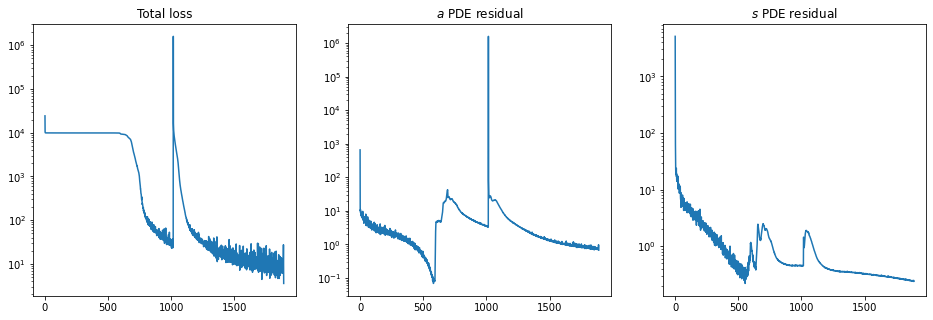

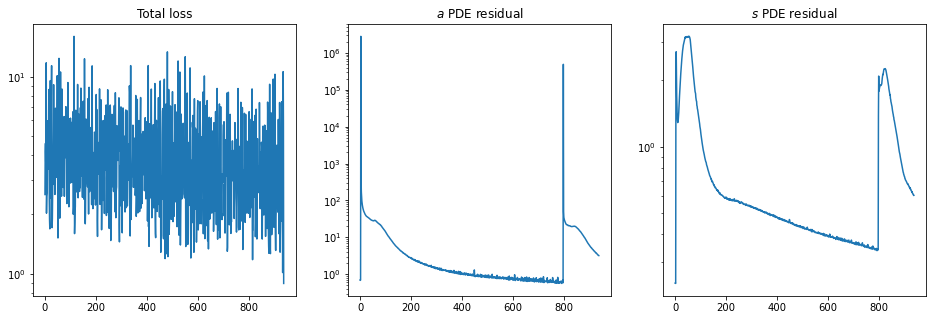

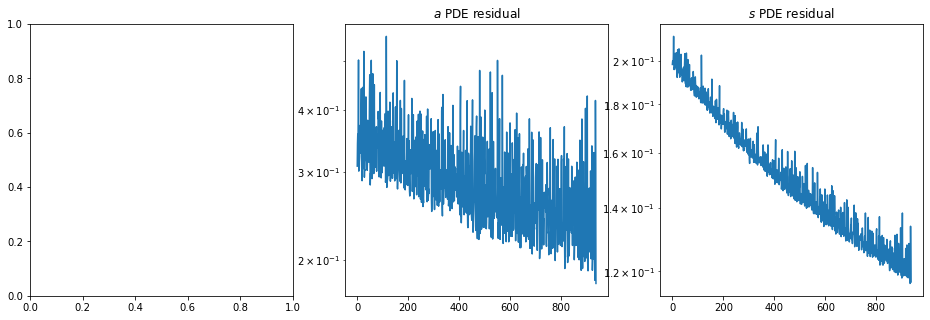

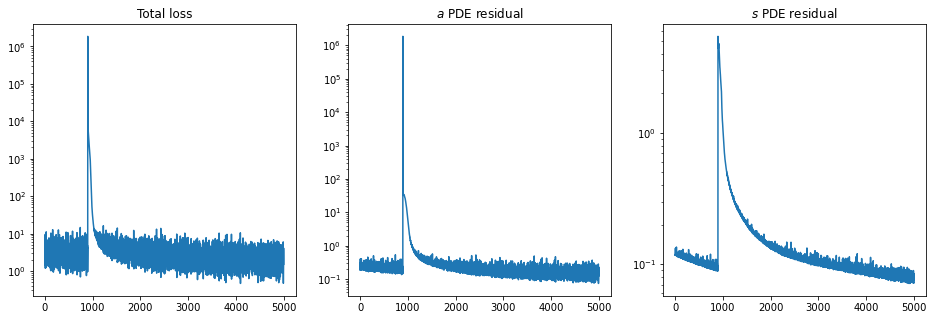

In [48]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")

plt.subplot(1,3,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")


plt.subplot(1,3,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")

plt.show()

start = 0
end = len(loss2)
_ = plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(loss2[start:end])
plt.yscale('log')
plt.title(r"Total loss")

plt.subplot(1,3,2)
plt.plot(loss_a2[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")


plt.subplot(1,3,3)
plt.plot(loss_s2[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")

plt.show()

start = 0
end = len(loss_a3)
_ = plt.figure(figsize=(16,5))
plt.subplot(1,3,1)

plt.subplot(1,3,2)
plt.plot(loss_a3[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")


plt.subplot(1,3,3)
plt.plot(loss_s3[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")

plt.show()

start = 0
end = len(loss4)
_ = plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(loss4)
plt.yscale('log')
plt.title(r"Total loss")

plt.subplot(1,3,2)
plt.plot(loss_a4[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")


plt.subplot(1,3,3)
plt.plot(loss_s4[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")

plt.show()

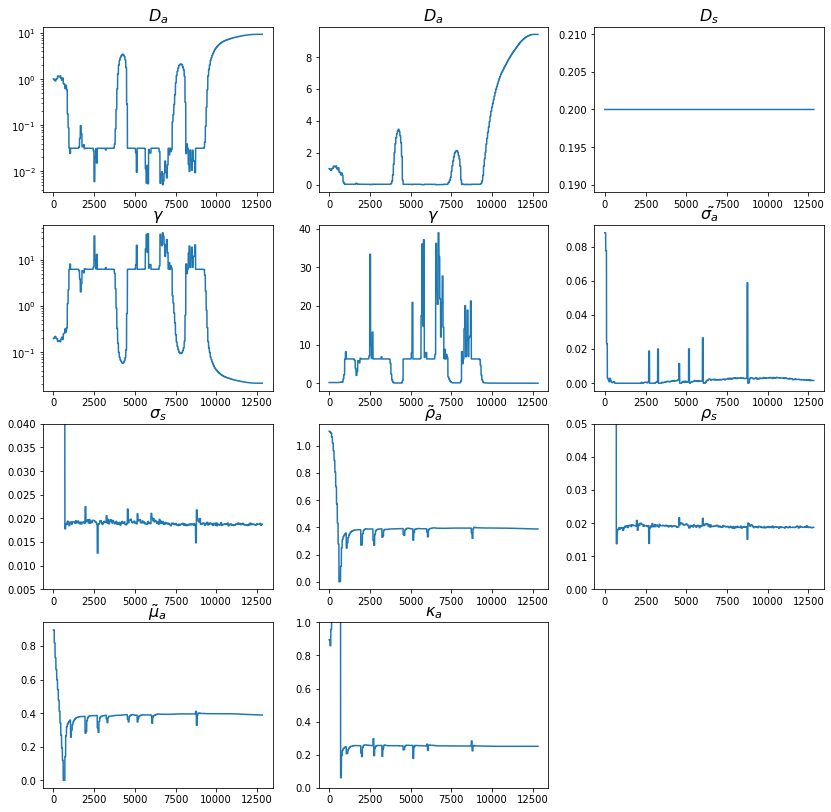

In [60]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))
plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates['D_a'],params_estimates2['D_a'],params_estimates3['D_a'],params_estimates4['D_a']])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates['D_a'],params_estimates2['D_a'],params_estimates3['D_a'],params_estimates4['D_a']])
plt.title(r"$D_a$", fontsize=16)


plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates['D_s'],params_estimates2['D_s'],params_estimates3['D_s'],params_estimates4['D_s']])
plt.title(r"$D_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates['gamma'],params_estimates2['gamma'],params_estimates3['gamma'],params_estimates4['gamma']])
plt.title(r"$\gamma$", fontsize=16)
plt.yscale('log')

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates['gamma'],params_estimates2['gamma'],params_estimates3['gamma'],params_estimates4['gamma']])
plt.title(r"$\gamma$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates['sigma_a'],params_estimates2['sigma_a'],params_estimates3['sigma_a'],params_estimates4['sigma_a']])
plt.title(r"$\tilde{\sigma_a}$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates['sigma_s'],params_estimates2['sigma_s'],params_estimates3['sigma_s'],params_estimates4['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')
plt.ylim([0.005,.04])

plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates['rho_a'],params_estimates2['rho_a'],params_estimates3['rho_a'],params_estimates4['rho_a']])
plt.title(r"$\tilde{\rho}_a$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,9)
plt.plot(np.r_[params_estimates['rho_s'],params_estimates2['rho_s'],params_estimates3['rho_s'],params_estimates4['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
#plt.yscale('log')
plt.ylim([0.0,.05])


plt.subplot(4,3,10)
plt.plot(np.r_[params_estimates['mu_a'],params_estimates2['mu_a'],params_estimates3['mu_a'],params_estimates4['mu_a']])
plt.title(r"$\tilde{\mu}_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,11)
plt.plot(np.r_[params_estimates['kappa_a'], params_estimates2['kappa_a'], params_estimates3['kappa_a'], params_estimates4['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
#plt.yscale('log')
plt.ylim([0,1])


plt.show()

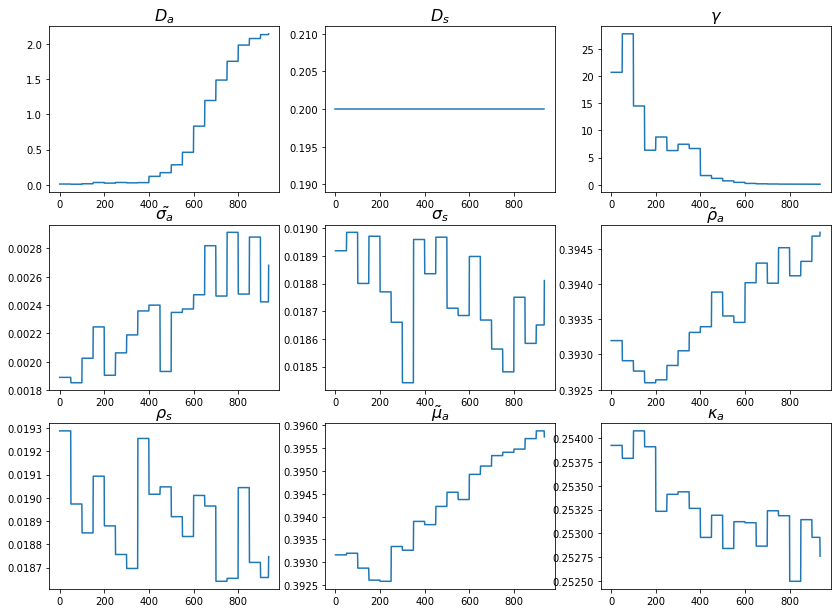

In [44]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))
plt.subplot(4,3,1)
plt.plot(params_estimates3['D_a'])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,2)
plt.plot(params_estimates3['D_s'])
plt.title(r"$D_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,3)
plt.plot(params_estimates3['gamma'])
plt.title(r"$\gamma$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,4)
plt.plot(params_estimates3['sigma_a'])
plt.title(r"$\tilde{\sigma_a}$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,5)
plt.plot(params_estimates3['sigma_s'])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,6)
plt.plot(params_estimates3['rho_a'])
plt.title(r"$\tilde{\rho}_a$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,7)
plt.plot(params_estimates3['rho_s'])
plt.title(r"$\rho_s$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,8)
plt.plot(params_estimates3['mu_a'])
plt.title(r"$\tilde{\mu}_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,9)
plt.plot( params_estimates3['kappa_a'])
plt.title(r"$\kappa_a$", fontsize=16)
#plt.yscale('log')


plt.show()

# Estimated parameters 

In [29]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

gamma = model.sess.run(model.gamma)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

D_a = model.sess.run(model.D_a)
sigma_a_tilde = model.sess.run(model.sigma_a_tilde)
rho_a_tilde = model.sess.run(model.rho_a_tilde)
mu_a_tilde = model.sess.run(model.mu_a_tilde)
kappa_a = model.sess.run(model.kappa_a)


print_vals("gamma", gamma, 0.2/0.005)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("sigma_a_tilde", sigma_a_tilde)
print_vals("rho_a_tilde", rho_a_tilde)
print_vals("mu_a_tilde", mu_a_tilde)
print()
print_vals("D_a", D_a, 0.005)
print_vals("sigma_a", sigma_a_tilde/gamma, 0.0)
print_vals("rho_a", rho_a_tilde/gamma,0.01)
print_vals("mu_a", mu_a_tilde/gamma, 0.01 )

gamma: 49.77443695, actual: 40.000, difference: 9.77443695, relative: %24.43609238
D_s: 0.20000000, actual: 0.200, difference: 0.00000000, relative: %0.00000149
sigma_s: 0.01859955, actual: 0.020, difference: 0.00140045, relative: %7.00225346
rho_s: 0.01897812, actual: 0.020, difference: 0.00102188, relative: %5.10939620

sigma_a_tilde: 0.00179807
rho_a_tilde: 0.39325854
mu_a_tilde: 0.39317998

D_a: 0.00401813, actual: 0.005, difference: 0.00098187, relative: %19.63746026
sigma_a: 0.00003612, actual: 0.000, difference: 0.00003612 
rho_a: 0.00790081, actual: 0.010, difference: 0.00209919, relative: %20.99186406
mu_a: 0.00789924, actual: 0.010, difference: 0.00210076, relative: %21.00764997


In [43]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.12f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.12f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

gamma = model.sess.run(model.gamma)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

D_a = model.sess.run(model.D_a)
sigma_a_tilde = model.sess.run(model.sigma_a_tilde)
rho_a_tilde = model.sess.run(model.rho_a_tilde)
mu_a_tilde = model.sess.run(model.mu_a_tilde)
kappa_a = model.sess.run(model.kappa_a)


print_vals("gamma", gamma, 0.2/0.005)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("sigma_a_tilde", sigma_a_tilde)
print_vals("rho_a_tilde", rho_a_tilde)
print_vals("mu_a_tilde", mu_a_tilde)
print()
print_vals("D_a", D_a, 0.005)
print_vals("sigma_a", sigma_a_tilde/gamma, 0.0)
print_vals("rho_a", rho_a_tilde/gamma,0.01)
print_vals("mu_a", mu_a_tilde/gamma, 0.01 )
print_vals("kappa_a", kappa_a, 0.25 )

gamma: 0.093277938664, actual: 40.000, difference: 39.90672206, relative: %99.76680515
D_s: 0.200000002980, actual: 0.200, difference: 0.00000000, relative: %0.00000149
sigma_s: 0.018810791895, actual: 0.020, difference: 0.00118921, relative: %5.94604053
rho_s: 0.018747147173, actual: 0.020, difference: 0.00125285, relative: %6.26426414

sigma_a_tilde: 0.00268014
rho_a_tilde: 0.39473224
mu_a_tilde: 0.39574626

D_a: 2.144129753113, actual: 0.005, difference: 2.13912975, relative: %42782.59506226
sigma_a: 0.028732823208, actual: 0.000, difference: 0.02873282 
rho_a: 4.231785774231, actual: 0.010, difference: 4.22178577, relative: %42217.85774231
mu_a: 4.242656707764, actual: 0.010, difference: 4.23265671, relative: %42326.56707764
kappa_a: 0.252759486437, actual: 0.250, difference: 0.00275949, relative: %1.10379457


In [32]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [33]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))

tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00551643
Loss_s : 0.00364775
Loss   : 0.03051512


In [34]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.012594075025888305
0.008756861849504426


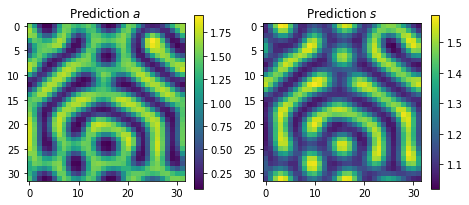

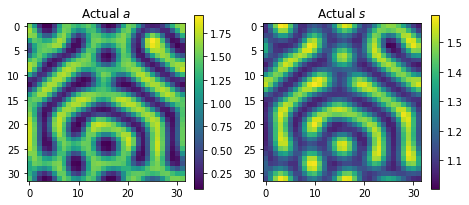

In [35]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [36]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

gamma = 0.09, D_a = 2.144130, rho_a_tilde = 0.394732, mu_a_tilde = 0.395746261, sigma_a_tilde = 0.002680138, kappa_a = 0.2528


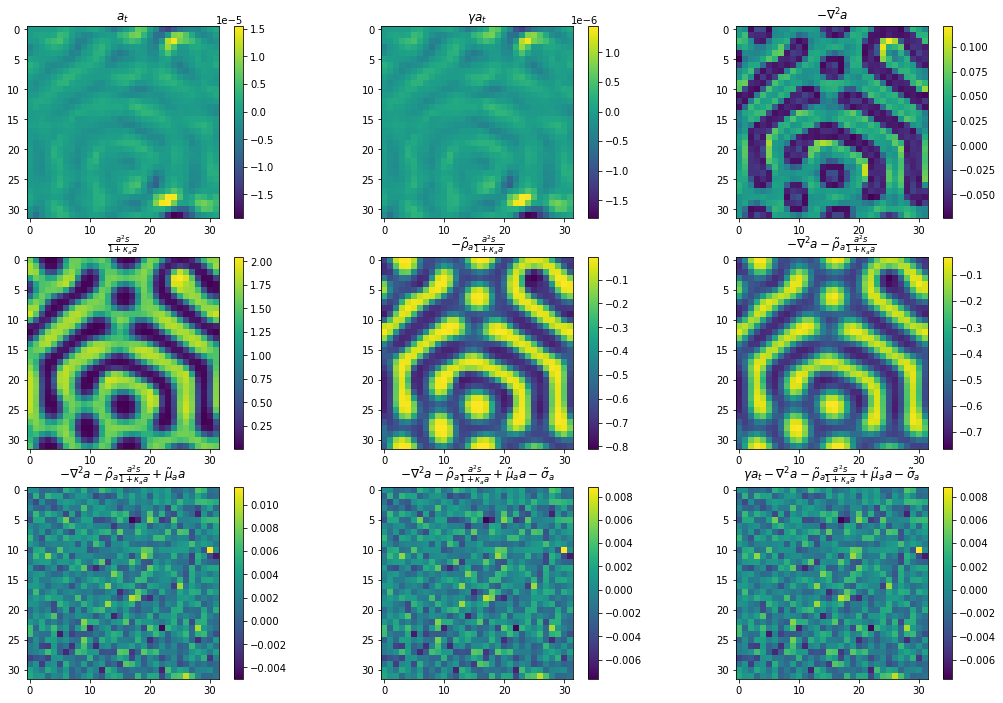

In [37]:
def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
        
gamma =  _get_val(model.sess.run(model.gamma))       
D_s = _get_val(model.sess.run(model.D_s))
sigma_s = _get_val(model.sess.run(model.sigma_s))
rho_s = _get_val(model.sess.run(model.rho_s))

D_a = _get_val(model.sess.run(model.D_a))
sigma_a_tilde = _get_val(model.sess.run(model.sigma_a_tilde))
rho_a_tilde = _get_val(model.sess.run(model.rho_a_tilde))
mu_a_tilde = _get_val(model.sess.run(model.mu_a_tilde))
kappa_a = _get_val(model.sess.run(model.kappa_a))
print(f"gamma = {gamma:.2f}, D_a = {D_a:.6f}, rho_a_tilde = {rho_a_tilde:.6f}, mu_a_tilde = {mu_a_tilde:.9f}, sigma_a_tilde = {sigma_a_tilde:.9f}, kappa_a = {kappa_a:.4f}")

# gamma*a_t - (a_xx + a_yy) - rho_a_tilde*f + mu_a_tilde*a - sigma_a_tilde
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 2)
plt.title(r"$\gamma a_t$")
plt.imshow((gamma*a_t).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 3)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 5)
plt.title(r"$ - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 6)
plt.title(r"$- \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-a_diff-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 7)
plt.title(r"$-\nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a$")
plt.imshow((-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 8)
plt.title(r"$- \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 9)
plt.title(r"$\gamma a_t-\nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((gamma*a_t-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


gamma = 0.09, D_s = 0.200000, rho_s = 0.018747, sigma_s = 0.018811, kappa_a = 0.2528


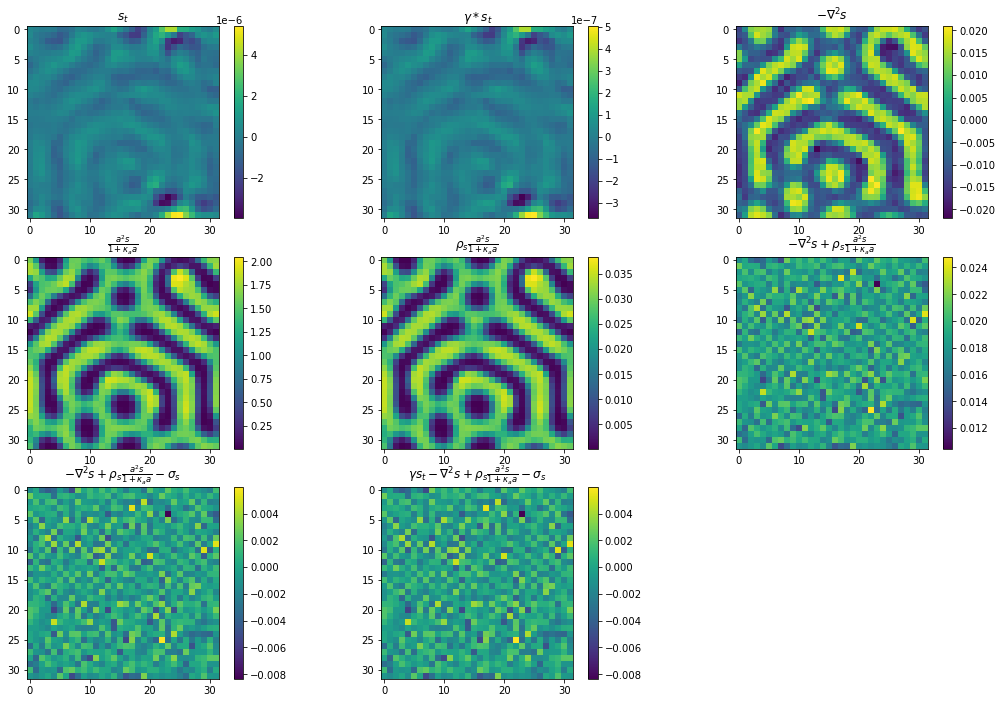

In [38]:
def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
        
gamma =  _get_val(model.sess.run(model.gamma))       
D_s = _get_val(model.sess.run(model.D_s))
sigma_s = _get_val(model.sess.run(model.sigma_s))
rho_s = _get_val(model.sess.run(model.rho_s))

D_a = _get_val(model.sess.run(model.D_a))
sigma_a_tilde = _get_val(model.sess.run(model.sigma_a_tilde))
rho_a_tilde = _get_val(model.sess.run(model.rho_a_tilde))
mu_a_tilde = _get_val(model.sess.run(model.mu_a_tilde))
kappa_a = _get_val(model.sess.run(model.kappa_a))

print(f"gamma = {gamma:.2f}, D_s = {D_s:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - (s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 2)
plt.title(r"$\gamma*s_t$")
plt.imshow((gamma*s_t).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 3)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)


plt.subplot(3, 3, 5)
plt.title(r"$\rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 6)
plt.title(r"$-\nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 7)
plt.title(r"$-\nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$\gamma s_t-\nabla^2 s +  \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((gamma*s_t-s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()